# Dataset: 

credit card fraud

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud



In [265]:
import torch
from torch import nn
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from collections import  defaultdict


In [44]:
ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'creditcard.csv')
assert os.path.exists(DATASET_PATH), f'path to dataset not found {DATASET_PATH}'

In [52]:
df = pd.read_csv(DATASET_PATH)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [53]:
# Calculate log10
df['log10_amount'] = np.log10(df.Amount + 0.00001)
df.drop(['Time', 'Amount'], axis = 1, inplace=True)

In [123]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,log10_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,2.174990
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.429754
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,2.578249
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,2.091667
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,1.845036


In [55]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'log10_amount'],
      dtype='object')

# Sampling clean data (to save computation)

In [137]:
# Sample the dataset to save computation
fraud_df = df[df.Class == 1]
clean_df = df[df.Class == 0]

print('fraud shape = ', fraud_df.shape)
print('clean shape = ', clean_df.shape)


fraud shape =  (492, 30)
clean shape =  (284315, 30)


In [138]:
clean_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,log10_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,2.174990
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.429754
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,2.578249
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,2.091667
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,1.845036


In [126]:
#sample a ratio of 15 clean to 1 fraud
clean_to_fraud_ratio = 15 
#only sample clean, we're training autoencoder on clean only
sampled_clean_df = clean_df.sample(int(len(fraud_df) * clean_to_fraud_ratio), random_state=42 ) 
print('sampled clean len = ', len(sampled_clean_df))
sampled_clean_df.head()

sampled clean len =  7380


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,log10_amount
138028,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,-0.597739,...,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0,-0.119181
63099,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,0.170547,...,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,0,0.621177
73411,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,2.051312,...,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,0,1.176092
164247,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,-1.238598,...,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,0,1.755875
148999,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,1.166335,...,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0,-5.000000


# Visualize with t-SNE

In [119]:
vis_df = pd.concat([fraud_df, sampled_clean_df])
print(vis_df.shape)
vis_df.head()

(7872, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,log10_amount
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,1,-5.000000
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1,2.723456
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1,2.380085
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,1,1.770852
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1,0.000004


In [129]:

tsne = TSNE(n_components=2)
vis_df = pd.concat([fraud_df, sampled_clean_df])
features = tsne.fit_transform(vis_df.drop('Class', axis = 1))
labels = vis_df['Class']
compressed = tsne.fit_transform(features)
print('compressed shape = ', compressed.shape)


compressed shape =  (7872, 2)


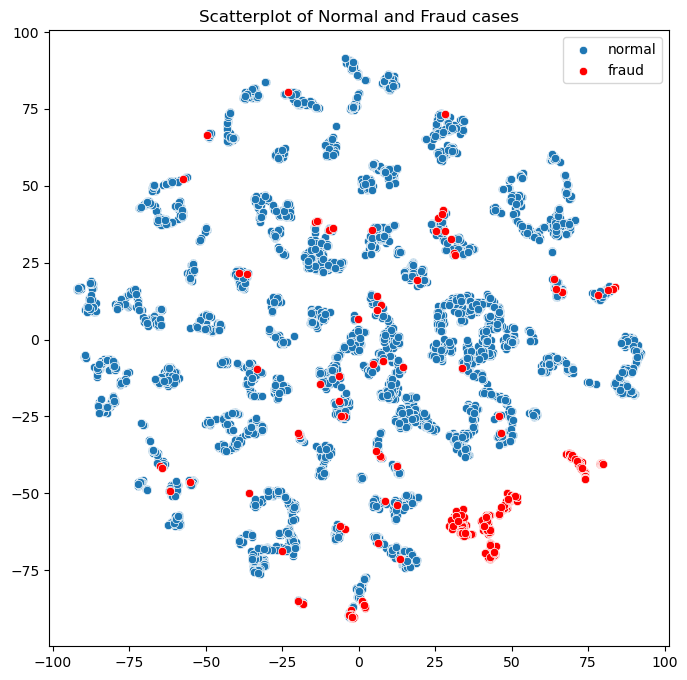

In [130]:
normal = compressed[np.where(labels == 0)] 
fraud = compressed[np.where(labels == 1)] 
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x = normal[:,0], y = normal[:,1], label = 'normal', ax =ax)
sns.scatterplot(x = fraud[:,0], y = fraud[:,1], label = 'fraud', ax = ax, color='red')
plt.title('Scatterplot of Normal and Fraud cases')
plt.show()

# Select clean and split it to train,valid, test

In [140]:
clean_df = clean_df.sample(frac = 1).reset_index(drop=True)
clean_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,log10_amount
0,2.118355,-0.969047,-2.528238,-1.674445,1.624608,3.409550,-1.526740,0.940946,-0.095614,0.097248,...,0.239463,0.660487,0.140296,0.604233,-0.113316,-0.067533,0.047785,-0.017227,0,1.342423
1,-0.332410,0.388149,1.942140,-0.359846,-0.565244,-0.730592,-0.027653,0.009289,0.576499,-0.884209,...,0.335375,1.059270,-0.190586,0.428590,-0.257579,-0.352093,0.212934,0.163717,0,0.930440
2,2.097126,-0.958639,-1.839906,-0.888371,-0.291254,-0.905410,-0.136652,-0.248659,-0.599035,0.974800,...,0.238351,0.585771,-0.058760,-0.374433,0.235904,-0.039056,-0.074472,-0.080922,0,1.845098
3,-0.676025,1.013440,2.041047,0.684047,-0.468443,-0.671199,0.509046,-0.074383,-0.066180,-0.242899,...,0.003062,0.348002,-0.232969,0.997512,0.107704,0.487697,0.199895,0.162944,0,0.599884
4,1.223738,-0.054467,0.691074,0.380946,-0.496130,-0.153311,-0.385787,-0.044866,0.392354,-0.145255,...,-0.028962,-0.075334,-0.080290,-0.400923,0.287914,0.437258,-0.006296,0.025317,0,1.548881


In [148]:
train, test = train_test_split(clean_df, shuffle=True)
train, valid = train_test_split(train.drop('Class', axis =1), shuffle=True)

#append fraud with test
test = pd.concat([test, fraud_df]).sample(frac = 1)

print('train shape = ', train.shape)
print('valid shape = ', valid.shape)
print('test shape = ', test.shape)


train shape =  (159927, 29)
valid shape =  (53309, 29)
test shape =  (71571, 30)


In [142]:
train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,log10_amount
212988,-0.184951,1.291562,-0.857712,-0.551001,0.707434,-0.753795,0.654006,0.311454,-0.247539,-1.071088,...,-0.306615,-0.861397,0.135957,0.376116,-0.355780,0.126739,0.096394,0.021008,0,1.000868
133662,-1.144887,0.506172,0.190439,-0.887941,0.783459,-1.528362,0.549467,0.220519,-0.255801,-1.176447,...,0.408509,0.843508,-0.417405,-0.092130,0.329009,-0.202614,-0.019097,-0.030838,0,0.000004
74108,0.992560,-0.725663,0.776679,0.157728,-0.803122,0.446579,-0.552261,0.163125,1.131158,-0.565277,...,-0.167312,-0.404675,-0.061559,-0.354773,0.115702,0.991273,-0.034808,0.026189,0,2.076713
28262,-0.925514,1.023498,1.485087,-0.787077,0.508082,-0.016270,0.698643,0.186929,-0.136151,-0.529748,...,-0.285632,-0.906396,-0.234127,-0.832464,0.250941,0.106850,0.101328,0.104278,0,0.698101
146500,1.202125,-0.109328,-0.341735,-0.065905,0.279147,-0.061489,0.126242,-0.221005,1.273866,-0.510800,...,-0.208126,-0.358470,-0.308700,-0.761349,0.649036,1.127093,-0.136575,-0.021134,0,1.903090


In [151]:
print(test['Class'].value_counts())
test.head()

Class
0    71079
1      492
Name: count, dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,log10_amount
126166,1.978758,-0.534872,-1.120915,0.477710,-0.145285,-0.139143,-0.203433,0.016151,1.714975,-0.325470,...,-0.381138,-0.840394,0.237382,0.440631,-0.025192,-0.357935,-0.015261,-0.046833,0,1.530840
35988,1.835891,-0.412702,-0.713315,1.427420,-0.035204,0.408799,-0.252936,0.121780,1.254238,-0.043205,...,-0.518458,-1.398749,0.368671,0.173159,-0.293232,-1.113416,0.036606,-0.017421,0,1.880814
233844,1.232690,0.081679,1.035211,0.383685,-0.945679,-1.068845,-0.361602,-0.226277,1.647526,-0.539977,...,-0.320102,-0.699642,0.202871,0.682907,-0.059030,0.729493,-0.089513,0.012515,0,0.999131
222389,-0.537593,0.855639,1.422929,-0.424661,0.253836,-0.356826,0.714388,-0.022930,0.115835,-0.698667,...,-0.048218,0.221052,-0.274256,-0.033535,0.038275,0.383701,0.335643,0.189618,0,0.698971
104815,-1.440917,-2.372535,0.243085,-1.968045,2.028432,-1.320677,-1.138807,0.068045,-2.907211,1.357480,...,-0.052863,-0.532672,0.294850,0.045380,0.059677,-0.177371,0.016188,0.158320,0,1.681241


# Scaling and Normalizing

In [157]:
pipeline = Pipeline([('normalizer' ,Normalizer()), ('scaler', MinMaxScaler())]) 
X_train = pipeline.fit_transform(train)
X_valid = pipeline.fit_transform(valid)

In [177]:
X_train = torch.tensor(X_train, dtype = torch.float32)
X_valid = torch.tensor(X_valid, dtype = torch.float32)
print(X_train.shape)
print(X_valid.shape)

torch.Size([159927, 29])
torch.Size([53309, 29])


/var/folders/_s/m9kt_szd4qq9brspl9hd44mc0000gn/T/ipykernel_16471/22086024.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype = torch.float32)
/var/folders/_s/m9kt_szd4qq9brspl9hd44mc0000gn/T/ipykernel_16471/22086024.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_valid = torch.tensor(X_valid, dtype = torch.float32)


# Autoencoder

In [244]:
# class Autoencoder(nn.Module):

#     def __init__(self, input_size, hidden_size, embedding_size) -> None:
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_size, 16),
#             nn.ReLU(),
#             nn.LazyLinear(8),
#             nn.ReLU(),
#             nn.LazyLinear(4),
#             nn.ReLU(),
#             nn.LazyLinear(2),
#             nn.ReLU()
#         )

#         self.decoder = nn.Sequential(
#             nn.LazyLinear(4),
#             nn.ReLU(),
#             nn.LazyLinear(8),
#             nn.ReLU(),
#             nn.LazyLinear(16),
#             nn.ReLU(),
#             nn.LazyLinear(input_size),
#             nn.ReLU()
#         )
    
#     def forward(self, X):
#         X = self.encoder(X)
#         return self.decoder(X)
        

In [256]:
class Autoencoder(nn.Module):

    def __init__(self, input_size, hidden_size, embedding_size) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.LazyLinear(hidden_size),
            nn.ReLU(),
            nn.LazyLinear(hidden_size),
            nn.ReLU(),
            nn.LazyLinear(embedding_size),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.LazyLinear(hidden_size),
            nn.ReLU(),
            nn.LazyLinear(hidden_size),
            nn.ReLU(),
            nn.LazyLinear(hidden_size),
            nn.ReLU(),
            nn.LazyLinear(input_size),
            nn.ReLU()
        )
    
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)
        

In [257]:
# Test the encoder
sampleX = torch.rand(10,5)
autoencoder = Autoencoder(5, 10, 3)
sampleY = autoencoder(sampleX)

print('output sample Y = ', sampleY.shape)

output sample Y =  torch.Size([10, 5])


/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [258]:
def tune(model, X_train, X_valid, optimizer, criterion, epochs = 1000):

    num_epochs = 20

    loop = tqdm(range(epochs))
    history = defaultdict(list)
    for e in loop:
        model.train()

        X_pred = model(X_train)

        loss = criterion(X_pred, X_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history['train loss'].append(loss.item())

        model.eval()
        with torch.no_grad():
            X_valid_pred = model(X_valid)
            val_loss = criterion(X_valid_pred, X_valid)
            history['valid loss'].append(val_loss.item())


        loop.set_description(f'e = {e}, train loss = {loss.item():.3f}, valid loss ={val_loss.item():.3f}')

    indices = list(range(len(history['train loss'])))
    sns.lineplot(y = history['train loss'], x =indices, label = 'train')
    sns.lineplot(y = history['valid loss'], x =indices, label = 'valid')
    plt.title("Loss")
    plt.show()

    return model

e = 999, train loss = 0.090, valid loss =0.092: 100%|██████████| 1000/1000 [01:39<00:00, 10.01it/s]


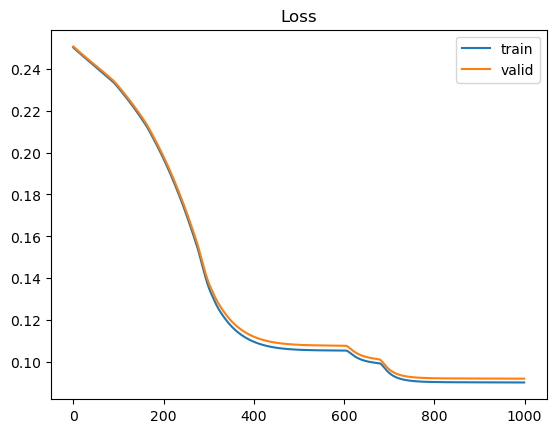

In [259]:
input_size = 29
embedding_size = 5
hidden_size = 32
lr = 0.0001
autoencoder = Autoencoder(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = lr)
model = tune(autoencoder, X_train, X_valid, optimizer, criterion, epochs = 1000)

# Predict fraud using Autoencoder

In [260]:
print(test.shape)
X_test = test.drop('Class', axis = 1).to_numpy()
#DO NOT FIT ON TEST DATA
#we want to see how good the model perform
X_test = pipeline.transform(X_test)

y_test = test['Class'].to_numpy()

reconstructions = autoencoder(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

#make sure they all numpy
print('X test shape = ', X_test.shape, ' type = ', type(X_test))
print('y test shape = ', y_test.shape, ' type = ', type(y_test))
print('reconstruction shape = ', reconstructions.shape, ' type = ', type(reconstructions))

squared_error = np.power(X_test - reconstructions, 2)

mse = np.mean(squared_error, axis = 1) 
print(mse.shape)

(71571, 30)
X test shape =  (71571, 29)  type =  <class 'numpy.ndarray'>
y test shape =  (71571,)  type =  <class 'numpy.ndarray'>
reconstruction shape =  (71571, 29)  type =  <class 'numpy.ndarray'>
(71571,)


/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


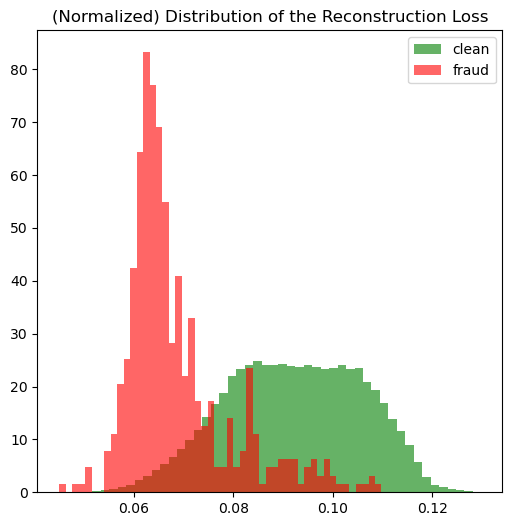

In [261]:
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [280]:
THRESHOLD = 1

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    median = np.median(points)
    ad = np.abs(points - median)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD
print(outliers)

print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

acc_score = accuracy_score(y_test, outliers)
print('accuracy = ', acc_score)
cm = confusion_matrix(y_test, outliers)
print(cm)

[False  True False ... False False False]
Detected 20,242 outliers in a total of 71,571 transactions [28.28%].
accuracy =  0.7217029243688086
[[51245 19834]
 [   84   408]]
